\begin{titlepage}
   \vspace*{\stretch{1.0}}
   \begin{center}
      \Large\textbf{Hashiwokakero}\\
      \vspace{3 in}
      \large\textit{Taha Bouhoun}
   \end{center}
   \vspace*{\stretch{2.0}}
\end{titlepage}

# Introduction:

Hashiwokakero is a Japanese logic puzzle (also known as bridges). It was first published by Nikoli Co., Ltd. [1] in September 1990. Unlike Sudoku, the literature on Hashiwokakero is rare. The rules are straightforward but the complexity araises as we solve bigger boards and to be entirely certain about a move, we need to think more than two steps ahead. The game is meant for entertainment as it was created by a gaming company but in my opinion, it can serve as an educational tool for teaching logic. Furthermore, I plan to implement a version that uses the puzzle as a reference in Chemistry, namely the concept of atoms and molecule bonds (e.g., Carbon has an atomic number of 5 which coresponds to its possible chemical bonds).

# The game settings:

The game can be played on a rectangular board with any dimensions $N\times M$ provided that either $N$ or $M$ is at least 3 Since the bridges that can be drawn on the borad are only vertical or horizontal (no diagonal links). The concept of the game is simple, yet it can be challenging given the rules.
The board contains nodes that each carry a value corresponding to the number of vertices that must be linked to the node. Since the possible number of vertices in each direction of a given node is 2, and the possible directions are 4, then the maximum value that a node can carry is 8.
An example board of Hashi puzzle is illustrated below:

An Example of a Hashiwokakero board with the proper solution - by Bsivko, 2018
wikimedia.org/wiki/File:Hashiwokakero_yuri_hasegawa.png


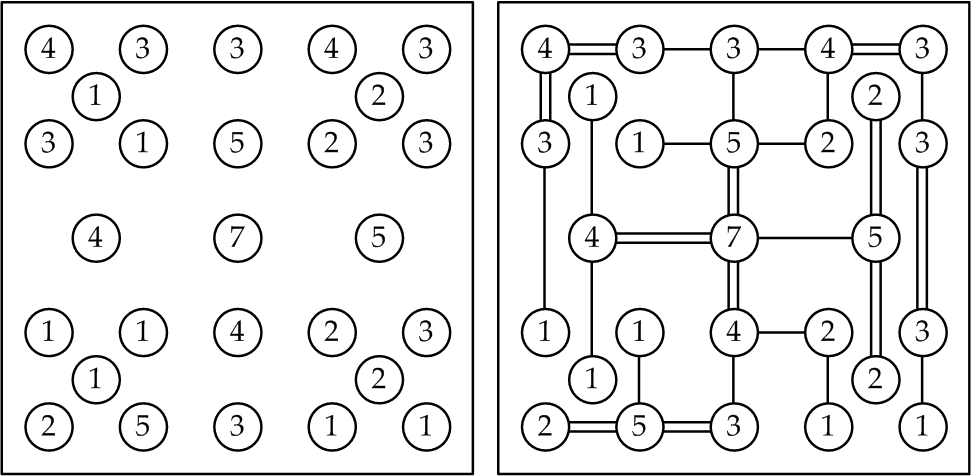

In [112]:
from PIL import Image 
print('An Example of a Hashiwokakero board with the \
proper solution - by Bsivko, 2018\n\
wikimedia.org/wiki/File:Hashiwokakero_yuri_hasegawa.png')
Image.open('Hashiwokakero.png')

The constraints of the solution are:

1. The possible number of bridges in each direction is either 1 or 2.

2. The bridges can't cross each other.

3. The bridges are either vertical of horizontal straight lines.

4. The total number of bridges going into a node must correspond to the value of the node.

5. All nodes must be connected either directly or through other nodes. In other words, there shouldn't be an isolated istands of connected nodes and the solution has to have all nodes connected in a single network.

# The logic of the game solver:

Personally, I have been playing the game for over two years. The App designed by Conceptis Puzzle [2] is a smooth interface to check both the possible directions that a given node has as well as if all nodes are eventually interconnected enabling passage from any "island" to another.
The heuristics on how to play the game which lead to a faster solution depends on the puzzle's level of difficulty. As a rule of thumb, starting by the nodes with the biggest values helps to build bridges that would minimize the options of the nodes with smaller values. The idea is to satisfy the constraints of the large nodes (and in doing so) we tighten the constraints of the smaller nodes.
It's important to note that the move must be certain, i.e., we don't draw a bridge unless we're certain that it's the only remaining options following this statement by sherlock Holmes:


\begin{center}
\textit{When you have eliminated the impossible, whatever remains, however improbable, must be the truth \\* - by Sir Arthur Conan Doyle.}
\end{center}


For simplicity reasons, we assume that all the puzzles suggested are solvable. It's true that some combinations of randomly generated boards can be unsolvable given the listed constraints, which would also conflict with the heuristics since we might run into cases where we can't make a move with 100% certainty.


## List of Heuristics:
$$[1]$$
\begin{center}
\textit{If a given node has value x and the possible directions that can be made is exactly $\frac{x}{2}$ \\* Then we can draw two bridges in all possible directions}
\end{center}


Examples are: an 8 in the middle of the borad (which is the only possible position), a 6 on the edge of the borad, and a 4 on the corner of the board.

$$[2]$$
\begin{center}
\textit{If a given node has value x and the possible directions that can be made is exactly $\frac{x}{2}-1$ \\* Then we can draw one bridges in all possible directions}
\end{center}


Examples are: an 7 in the middle of the borad (which is the only possible position), a 5 on the edge of the borad, and a 3 on the corner of the board.

$$[3]$$
\begin{center}
\textit{A node has value 4 with 3 possible directions to connect. If the 3 adjacent nodes \\* have values <2,2,2> or <2,2,1> Then we can draw one bridge from that node to each of the three directions}
\end{center}

$$[4]$$
\begin{center}
\textit{A node has value 2 with 2 possible directions to connect. If the 2 adjacent nodes \\* have values <2,2> Then we can draw one bridge from that node to each of the two directions}
\end{center}

$$[5]$$
\begin{center}
\textit{A node with value 1 should never be connected to another node with value 1}
\end{center}

Illustrating the case of heuristic 3 and 4, 
not abiding with these rules would lead us to construct
isolated islands which wouldn't connect with the rest of the network


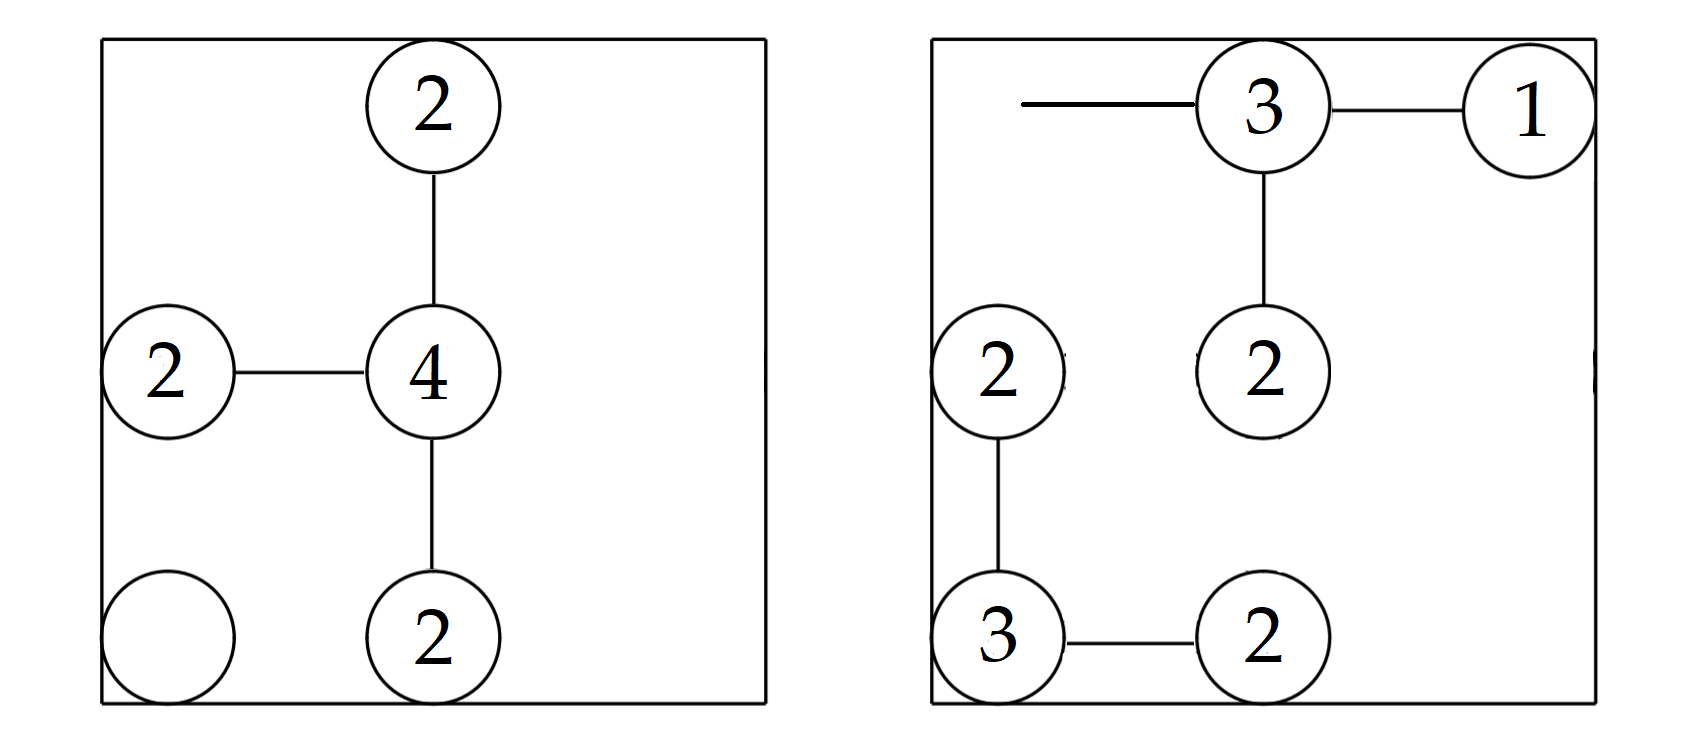

In [115]:
print("Illustrating the case of heuristic 3 and 4, \n\
not abiding with these rules would lead us to construct\n\
isolated islands which wouldn't connect with the rest of the network")
Image.open('h3_4.png')

# Pseudo-code of Prolog implementation

The following code breaks down the puzzle using the framework of *Constraint Satisfaction Problem* The steps are:

1. Setting the format of the node:

In [ ]:
node([]).
node[Head|Tain]):-
    assert(nodeItem(Head)),
    node(Tail).

2. Finding adjacent nodes:

In [ ]:
# Considering the dimensions of the puzzle to be MxN
left(_,[[_,Y],_]):- Y < 0, !.
right(_,[[_,Y],_]):- dimBoard(_,N), Y > N.
up(_,[[X,_],_]):- X < 0, !.
down(_,[[X,_],_]):- dimBoard(M,_), X > M.

nodeAdjacency([[X,Y],_]):-
    left([[X,Y],_], [[X,Y],_]),
    right([[X,Y],_], [[X,Y],_]),
    up([[X,Y],_], [[X,Y],_]),
    down([[X,Y],_], [[X,Y],_]), !.

3. Findig adjecent nodes of all islands:

First, we need to ensure that the nodes are distinct, because we can't link a bridge to the node itself, hence, the nodes have different coordinates (X1,Y1) and (X2,Y2).

Second, we need to check whether we've exhausted the maximum number of bonds between the two nodes. As mentioned in the game description, two bridges are the limit, as a result, we set <code>MaxBridge</code> to be strictly smaller than 2 for the possibility of making a new bridge.

Third, the variable $N_i$ correspond to the updated value of each node (i.e., the remaining bridges that can be drawn from the node). This values can be expressed as: $$N_i=Initial\ node\ value\ -\ Connected\ bridges$$
For both nodes under consideration, both values have to be greater than 0 for it to be possible to at least draw one bridge between them.

Forth, the above conditions are met, therefore, we assert a bridge between the nodes, then update their $N$'s.

Finally, we update the status of the island (the ensemble of the nodes and the bridges that connect them). Unless it's the whole network, we need to ensure that at least one of the nodes in that local island still have a possible bridge to draw since the aim is to have all nodes connected at the end.

In [ ]:
drawBridge([[X1,X2],_],[[Y1,Y2],_]):-
    
    adjacent([[X1,X2], [Y1,Y2]]),
    
    countBridges([[X1,X2],_], [[Y1,Y2],_], MaxBridge),
    MaxBridge < 2,
    
    island([[X1,X2], N1]), island([[Y1,Y2], N2]),
    N1 > 0, N2 > 0,
    
    assert(bridge([[X1,X2], N1],[[Y1,Y2], N2])),
    Nn1 is N1-1, Nn2 is N2-1,
    
    assert(island([[X1,X2],Nn1])), 
    retract(island([[X1,X2],N1])),
    
    assert(island([[Y1,Y2],Nn2])),
    retract(island([[Y1,Y2],N2])).

In [ ]:
countBridges(Island, MaxBridge):-
    findall(Island, bridge(Island, _), Result), 
    length(Result, MaxBridge).

drawBridge([]).

drawBridge([[[[A1,A2],N1],[[B1,B2],N2]]|Tail]):-
    drawBridge([[A1,A2],N1], [[B1,B2],N2]);
    drawBridge(Tail).

In [ ]:
# DEFINING THE SYMBOLS FOR DISPLAY
symbol(0, 0, '0'). # No links
symbol(0, 1, '-'). # One horizontal link
symbol(0, 2, '='). # Two horizontal links
symbol(1, 0, '|'). # One vertical link
symbol(2, 0, 'X'). # Two vertical links

# EXAMPLE OF THE INPUT FORMAT OF THE PUZZLE
"""
board(
       [[3, 0, 6, 0, 0, 0, 6, 0, 3],
        [0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 1, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0],
        [2, 0, 0, 0, 0, 1, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0],
        [1, 0, 3, 0, 0, 2, 0, 0, 0],
        [0, 3, 0, 0, 0, 0, 4, 0, 1]]
     ).
"""
# EXAMPLE OF THE OUTPUT FORMAT
"""
board(
       [[3, =, 6, =, =, =, 6, =, 3],
        [|, 0, X, 0, 0, 0, X, 0, |],
        [|, 1, X, 0, 0, 0, X, 0, |],
        [|, |, X, 0, 0, 0, X, 0, |],
        [2, |, X, 0, 0, 1, X, 0, |],
        [|, |, X, 0, 0, |, X, 0, |],
        [|, |, X, 0, 0, |, X, 0, |],
        [1, |, 3, -, -, 2, X, 0, |],
        [0, 3, =, =, =, =, 4, 0, 1]]
"""

# Python implementation

The puzzle is suited more as a CSP, but it would be interesting to implement a Python version that satisfies the listed constraints. The following code excutes an elimination search to generate/solve the puzzle of any given dimensions $N\times M$ and any given number of nodes. As a rule of thumb, we can set the nodes to cover at most $20\%$ of the possible positions on the board:
$$Nodes=int\left[\left(0.2\right)\cdot M\times N\right]$$

In [201]:
import random as rn

M, N = 10, 10  # Dimensions of the board
num_nodes = 15 # Number of nodes

def opposite_direc(direc):
    return tuple([-1 * item for item in direc])


initial = False
while not initial:
    # Create a board to be filled
    board = [[' ' for x in range(N)] 
                  for y in range(M)]

    # Set an arbitrary position for the first node
    x, y = rn.randrange(0, M), rn.randrange(0, N)
    
    board[x][y] = ' '
    nodes = [(x, y)]
    direcs = {nodes[-1]: []}
    iters = 0  # Number of tries to position a node in a solvable setup

    while num_nodes > 1 and iters < 99:
        iters += 1
        curr_node = rn.choice(nodes)
        # Check the directions the node can be connected through
        if len(direcs[curr_node]) == 4:
            continue
        # If all directions are filled
        direc_filled = True
        
        while direc_filled:
            dx, dy = rn.choice([-1, 0, 1]), rn.choice([-1, 0, 1])
            direc = (dx, dy)
            direc_filled = direc in direcs[curr_node] or (abs(dx) == abs(dy))

        x, y = curr_node[0], curr_node[1]

        # Fill out the possible bridges
        double_bridge = rn.choice([0, 1]) > 0
        if dx == 0:
            bridge = '=' if double_bridge else '-'
            dist_avail = y if dy < 0 else N - y 
        else:
            bridge = 'X' if double_bridge else '|'
            dist_avail = x if dx < 0 else N - x
        try:
            dist = rn.randrange(2, dist_avail)
        except ValueError:
            continue

        d = 0
        new_node = tuple(a + b for a, b in zip(curr_node, direc))
        x, y = new_node[0], new_node[1]
        bridges = [(x, y)]
        
        try:
            if board[x][y] != ' ' or board[x+dx][y+dy] != ' ' or\
            x < 0 or x+dx < 0 or y < 0 or y+dy < 0:
                continue
        except IndexError:
            continue

        direcs[curr_node].append(direc)
        while d < dist and board[x][y] == ' ' and 0 <= x < M and 0 <= y < N:
            new_node = tuple(a + b for a, b in zip(new_node, direc))
            x, y = new_node[0], new_node[1]
            bridges.append((x, y))
            d += 1
        
        new_node = tuple(a - b for a, b in zip(new_node, direc))
        bridges.remove((x, y))

        # Add a bridge along the distance between the two nodes
        for (x, y) in bridges:
            board[x][y] = bridge

        x, y = new_node[0], new_node[1]
        board[x][y] = ' '
        nodes.append(new_node)

        # If A to B is teken then so is the direction B to A
        if new_node in direc:
            direcs[new_node].append(opposite_direc(direc))
        else:
            direcs[new_node] = [opposite_direc(direc)]
        
        # Decrement the number of nodes
        num_nodes -= 1
        # Restart the interation counter
        iters = 0
    
    # The borad is generated and is solvable
    if num_nodes == 1:
        initial = True

initial_board = [[' ' for x in range(N)] 
                      for y in range(M)]

for x in range(M):
    for y in range(N):
        if board[x][y] == ' ':
            # Counter of the number of bridges
            count = 0
            for dx in [-1, 0, 1]:
                for dy in [-1, 0, 1]:
                    if abs(dx) == abs(dy):
                        continue
                    try:
                        if (board[x+dx][y+dy] == '|' and dx != 0) or \
                           (board[x+dx][y+dy] == '-' and dy != 0):
                            count += 1
                            
                        if (board[x+dx][y+dy] == 'X' and dx != 0) or \
                           (board[x+dx][y+dy] == '=' and dy != 0):
                            count += 2
                    except IndexError:
                        pass

            board[x][y] = count
            initial_board[x][y] = count

In [202]:
print('\nPuzzle:')
[[str(_).replace(' ','0') for _ in i] for i in initial_board]


Puzzle:


[['0', '1', '0', '0', '0', '0', '0', '2', '0', '0'],
 ['0', '0', '1', '0', '0', '0', '0', '0', '0', '2'],
 ['0', '0', '0', '0', '3', '0', '1', '0', '0', '0'],
 ['0', '0', '3', '0', '0', '0', '0', '0', '0', '0'],
 ['0', '0', '0', '0', '8', '0', '2', '0', '0', '0'],
 ['0', '0', '0', '0', '0', '0', '0', '0', '0', '3'],
 ['0', '0', '0', '0', '0', '0', '0', '0', '0', '0'],
 ['0', '0', '0', '0', '0', '0', '0', '0', '0', '0'],
 ['0', '0', '0', '0', '0', '0', '0', '0', '0', '0'],
 ['0', '0', '4', '0', '5', '0', '0', '4', '0', '3']]

In [203]:
print('\nSolution:')
[[str(_).replace(' ','0') for _ in i] for i in board]


Solution:


[['0', '1', '-', '-', '-', '-', '-', '2', '0', '0'],
 ['0', '0', '1', '0', '0', '0', '0', '|', '0', '2'],
 ['0', '0', '|', '0', '3', '-', '1', '|', '0', 'X'],
 ['0', '0', '3', '0', 'X', '0', '0', '|', '0', 'X'],
 ['0', '0', 'X', '=', '8', '=', '2', '|', '0', 'X'],
 ['0', '0', 'X', '0', 'X', '0', '0', '|', '0', '3'],
 ['0', '0', 'X', '0', 'X', '0', '0', '|', '0', '|'],
 ['0', '0', 'X', '0', 'X', '0', '0', '|', '0', '|'],
 ['0', '0', 'X', '0', 'X', '0', '0', '|', '0', '|'],
 ['0', '0', '4', '=', '5', '-', '-', '4', '=', '3']]

# Conclusion

Despite the scares literature on the puzzle, this paper synthesizes a potential Prolog implementation. The challenge was to find a syntax that can communicate the constraint of crossing to Prolog, because as we solve the puzzle we generate new constraints on the rest of the nodes.

The implementation in Python gives an example on generating a solvable board, the aim was to highlight that following the constraints of the game led us to design a new board. The backtraking logic is the essence of Prolog which made me beleive that it should indeed be feasible to implement it. Nevertheless, working on this puzzle was as entertaining as playing it. It might be true that adversarial aspect is not relevent in this context, but solving it in a timely manner is quite the challenge. 

# Appendix

1. Hashi puzzle by Conceptis:

An example of the interface to highlight both the possible bridges that can be drawn as well as the interconnectedness of the whole network of nodes.

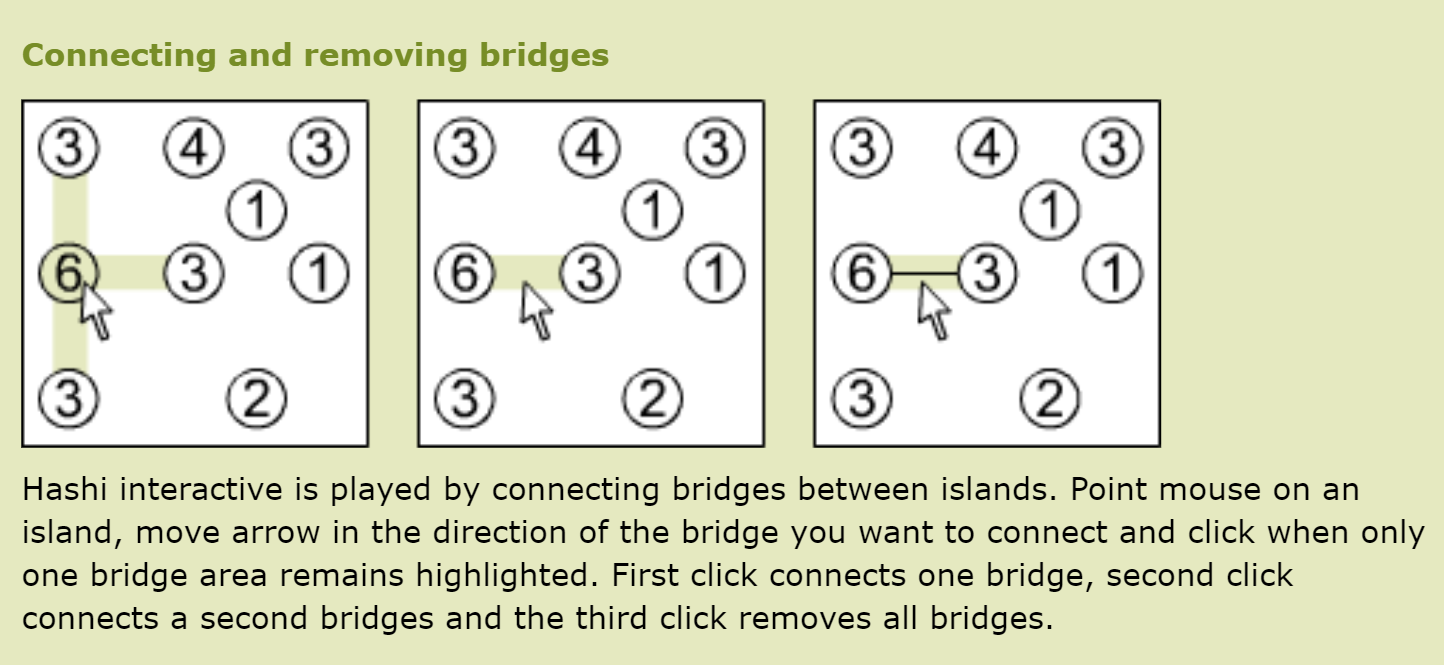

In [204]:
Image.open('coceptis_1.png')

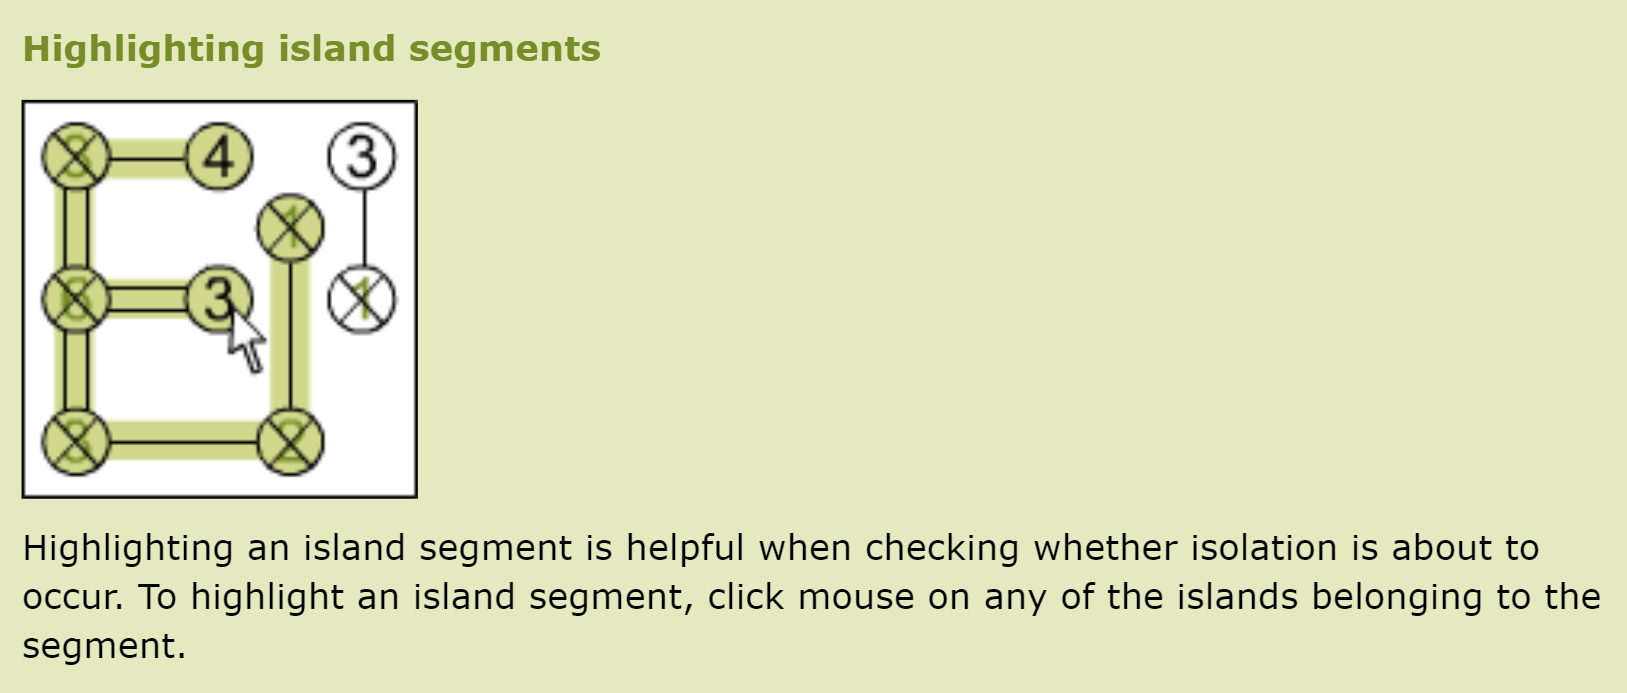

In [205]:
Image.open('coceptis_2.png')

2. HC/LO Applications:
    - #constraint: The Hashi puzzle is a strong example of considering cconstraints to solve a given problem. Using the *Constraint Satisfaction Probelm* framework, I proposed a Prolog pseudo-code and a Python implementation that yeild a solution just by working on satisfying those constraints.
    - #heuristics: Listing all the heuristics that helps find a faster solution to the puzzle granted that the puzzle is solvable (e.g., starting with nodes with larger values and draw the bridges that would narrow down the options of the nodes with smaller values).
    - #LO-aiconcept: Upon extensive research on the puzzle, In addition to actually emailing a handful number of authors that have published a paper on the topic, I concluded that the puzzle NP-Complete [3] As prooved before by (Andersson, 2009). The use of AI concepts was prominent throughout the paper, starting by the logic of the game, then listing the constraints that must be followed by an AI with a purpose to solve the puzzle. The AI concept used is *Constraint Satisfaction Probelm* 

# References
1. T. Morsink (2009). Hashiwokakero. Retrieved from: https://theses.liacs.nl/pdf/2009-11TimoMorsink.pdf
2. Conceptis Puzzles (1997-2019). Hashi puzzle. Retrieved from: https://www.conceptispuzzles.com/index.aspx?uri=puzzle/hashi
3. Andersson, D. (2009). Hashiwokakero is np-complete. Information Processing Letters, 109(19), 1145-1146. doi:10.1016/j.ipl.2009.07.017
4. Yen, S., Chiu, S., Chou, C., Su, T., & 2011 IEEE International Conference on Fuzzy Systems, FUZZ 2011 Taipei, TWN 2011 06 27 - 2011 06 30. (2011). Elimination search for puzzle games: An application for hashi solver.
5. Benchmark instances and branch-and-cut algorithm for the Hashiwokakero puzzle. Coelho, L.; Laporte, G.; Lindbeck, A.; and Vidal, T. Technical Report PUC-Rio, 2019. Retrieved from: https://arxiv.org/pdf/1905.00973.pdf
6. Brain, M., Cliffe, O., & De Vos, M. (2009). A pragmatic programmer’s guide to answer set programming. 49-63. Paper presented at Software Engineering for Answer Set Programming (SEA09), Potsdam, Germany. Retrieved from:http://ceur-ws.org/Vol-546/49-63.pdf